# Imports

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import graphviz
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_probability as tfp
import keras
import seaborn as sns
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from xgboost import plot_tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_predict, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_percentage_error, accuracy_score, mean_squared_error, classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, RidgeClassifier, Lasso
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from scipy.stats import norm, randint, uniform, median_abs_deviation
import math
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


warnings.filterwarnings('ignore')


In [ ]:
train_df = pd.read_csv("https://raw.githubusercontent.com/enosnas/DSO-530/main/option_train.csv")
train_df.set_index(train_df.columns[0],inplace=True)
train_df.drop(train_df.columns[5], axis=1, inplace=True)

pred_df = pd.read_csv("https://raw.githubusercontent.com/enosnas/DSO-530/main/option_test_nolabel.csv")
pred_df.set_index(pred_df.columns[0], inplace=True)
pred_df['Value']=np.nan

# Exploratory Data Analysis

In [ ]:
# Initialize the StandardScaler
standard_scaler = StandardScaler()


X_train = train_df.drop(['Value'], axis=1)
y_train = train_df['Value']

# Z-score Normalization (Standardization)
X_train_standard = standard_scaler.fit_transform(X_train)

# Convert the normalized arrays back to dataframes for easier interpretation
X_train_standard_df = pd.DataFrame(X_train_standard, columns=X_train.columns, index=X_train.index)

X_train_standard_df.head()

,S,K,tau,r
Unnamed: 0,,,,
1,-0.574242,-1.854747,-0.860212,0.295313
2,0.100027,0.172337,1.522042,-0.373826
3,0.932380,-0.841205,0.502769,-0.596872
4,-1.012632,0.751504,-0.907620,0.964453
5,-1.074546,-0.117247,-0.125387,0.964453


Attempting outlier removal based on modified z scores

In [ ]:
#Initializing the clean_train_df

clean_train_df=train_df.copy()
#clean_train_df

In [ ]:
#For Value
median = np.median(clean_train_df['Value'])
median_absolute_deviation = median_abs_deviation(clean_train_df['Value'])
threshold=3.5
z_scores = []

for i in clean_train_df['Value']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(Value_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [ ]:
#For S
median = np.median(clean_train_df['S'])
median_absolute_deviation = median_abs_deviation(clean_train_df['S'])
threshold=3.5
z_scores = []

for i in clean_train_df['S']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(S_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [ ]:
#For K
median = np.median(clean_train_df['K'])
median_absolute_deviation = median_abs_deviation(clean_train_df['K'])
threshold=3.5
z_scores = []

for i in clean_train_df['K']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(K_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [ ]:
#For tau
median = np.median(clean_train_df['tau'])
median_absolute_deviation = median_abs_deviation(clean_train_df['tau'])
threshold=3.5
z_scores = []

for i in clean_train_df['tau']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(tau_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [ ]:
#For r
median = np.median(clean_train_df['r'])
median_absolute_deviation = median_abs_deviation(clean_train_df['r'])
threshold=3.5
z_scores = []

for i in clean_train_df['r']:
      modified_z_scores = 0.6745 * (i - median) / median_absolute_deviation
      if np.abs(modified_z_scores) < threshold:
        z_scores.append(modified_z_scores)
      else:
        z_scores.append(np.nan)

clean_train_df=clean_train_df.assign(r_z_score=z_scores)
clean_train_df=clean_train_df.dropna()

In [ ]:
clean_train_df.describe()

,Value,S,K,tau,r,Value_z_score,S_z_score,K_z_score,tau_z_score,r_z_score
count,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000,4704.000000
mean,128.741264,1426.533099,1379.355867,0.302658,0.011470,0.228171,-0.131768,-0.139245,0.390444,0.157584
std,109.338283,56.103503,156.880978,0.204727,0.000448,1.056382,0.949368,1.058162,1.145504,1.007547
min,0.281250,1264.740000,900.000000,0.084932,0.010600,-1.012958,-2.869586,-3.372500,-0.827795,-1.798667
25%,43.000000,1387.120000,1275.000000,0.139726,0.011100,-0.600226,-0.798705,-0.843125,-0.521205,-0.674500
50%,98.812500,1433.475000,1400.000000,0.219178,0.011400,-0.060989,-0.014299,0.000000,-0.076648,0.000000
75%,188.875000,1469.440000,1475.000000,0.428082,0.011700,0.809158,0.594291,0.505875,1.092230,0.674500
max,466.000000,1527.460000,1900.000000,0.857534,0.012900,3.486628,1.576090,3.372500,3.495136,3.372500


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   5000 non-null   float64
 1   S       5000 non-null   float64
 2   K       5000 non-null   int64  
 3   tau     5000 non-null   float64
 4   r       5000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 234.4 KB


In [ ]:
train_df.describe()

,Value,S,K,tau,r
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,140.316869,1426.643916,1370.244000,0.327615,0.011468
std,125.155000,56.051523,172.679107,0.231184,0.000448
min,0.281250,1264.740000,750.000000,0.084932,0.010600
25%,45.750000,1387.670000,1275.000000,0.142466,0.011100
50%,105.125000,1434.320000,1400.000000,0.238356,0.011400
75%,200.406250,1469.440000,1475.000000,0.463014,0.011700
max,685.500000,1527.460000,1995.000000,0.989041,0.012900


In [ ]:
#Filtered training data set to account for possible outliers using z score analysis

#Split the data while retaining the column names
x3, y3 = clean_train_df.iloc[:, 1:5], clean_train_df.iloc[:, 0:1]

# Data Visualizations


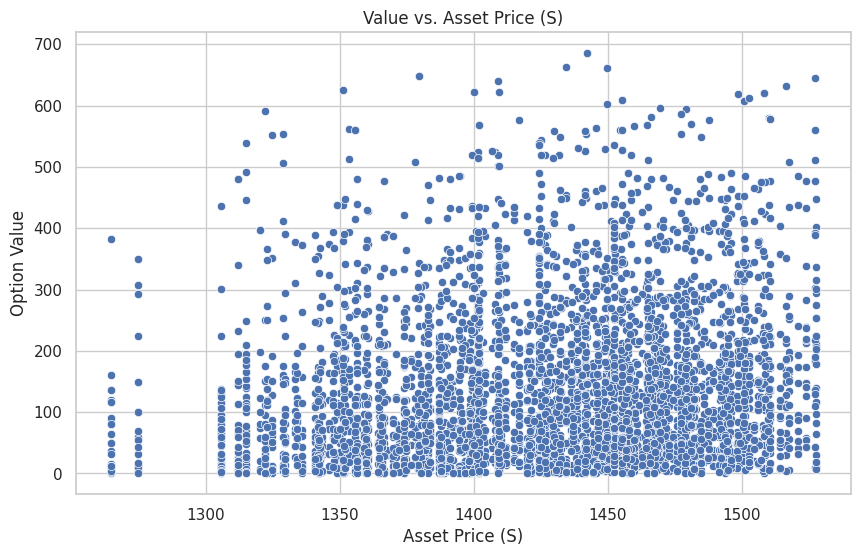

In [ ]:
# Scatter plot of Value vs. S in unfiltered data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='S', y='Value', data=train_df)
plt.xlabel('Asset Price (S)')
plt.ylabel('Option Value')
plt.title('Value vs. Asset Price (S)')
plt.show()

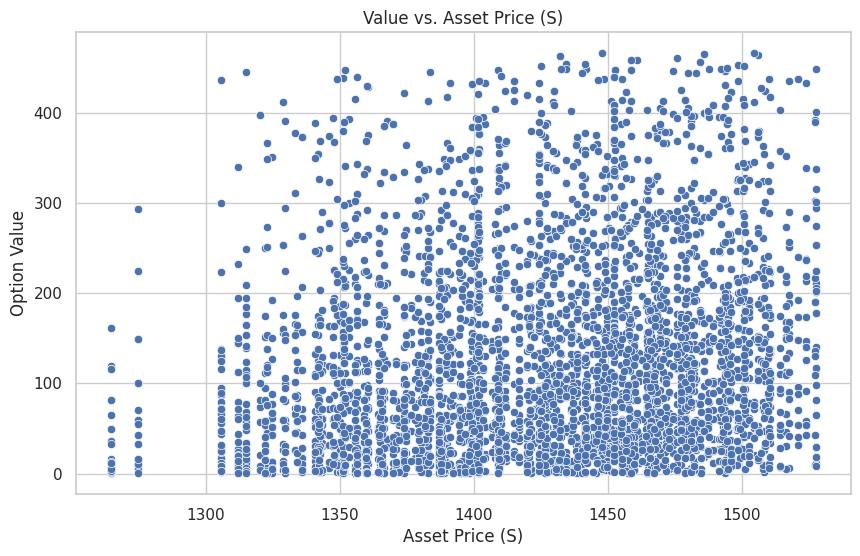

In [ ]:
# Scatter plot of Value vs. S in filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='S', y='Value', data=clean_train_df)
plt.xlabel('Asset Price (S)')
plt.ylabel('Option Value')
plt.title('Value vs. Asset Price (S)')
plt.show()

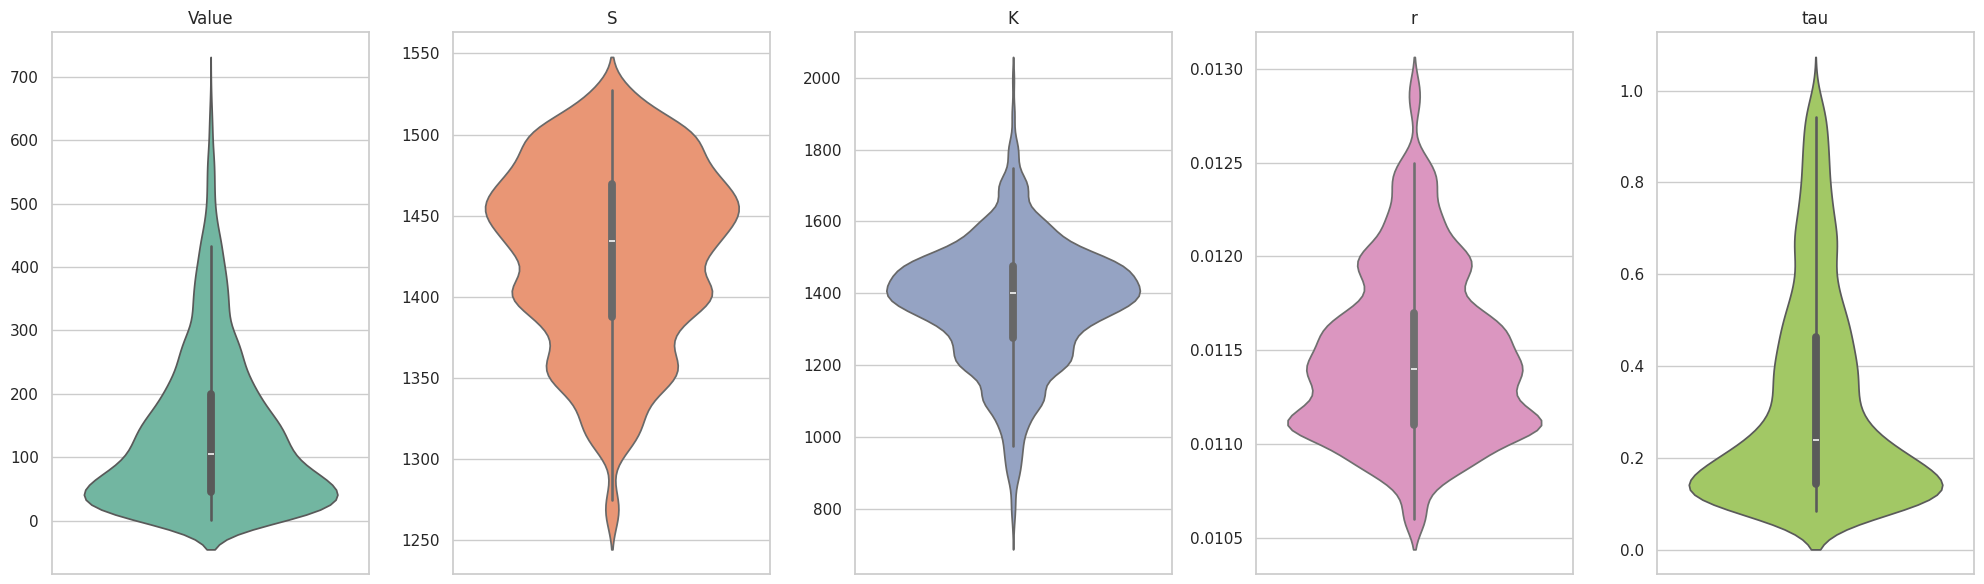

In [ ]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")
colors = sns.color_palette("Set2")

# Create a figure with subplots for violin plots
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

# Define the features for which you want to create violin plots
features = ['Value', 'S', 'K', 'r', 'tau']

# Plot violin plots for each feature with different colors
for i, feature in enumerate(features):
    sns.violinplot(y=feature, data=train_df, ax=axs[i], color=colors[i])
    axs[i].set_title(feature)
    axs[i].set_ylabel('')  # Remove y-axis label for cleaner look
    axs[i].set_xlabel('')  # Remove x-axis label for cleaner look

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

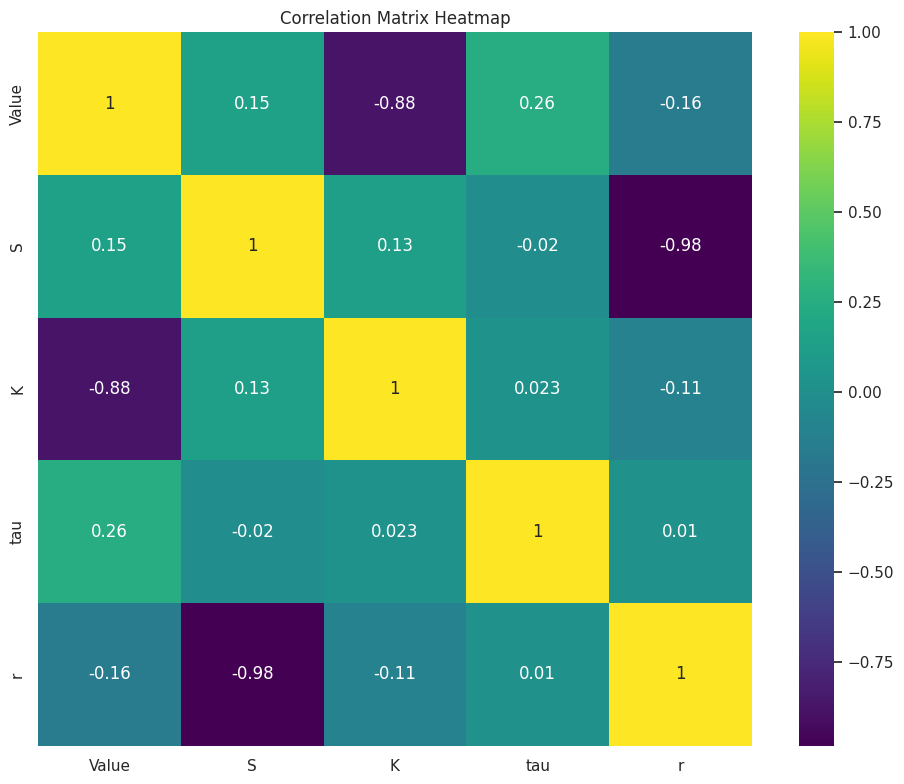

In [ ]:
corr_matrix1=train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix1, annot=True, cmap='viridis', square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=train_df['S'],
    y=train_df['K'],
    z=train_df['Value'],
    mode='markers',
    marker=dict(
        size=5,
        color=train_df['Value'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=train_df.index,
    hoverinfo='text+x+y+z'
)])

# Customize the layout
fig.update_layout(
    title='3D Scatter Plot of Value, Asset Price, and Strike Price',
    scene=dict(
        xaxis_title='Asset Price (S)',
        yaxis_title='Strike Price (K)',
        zaxis_title='Option Value'
    ),
    width=800,
    height=600
)

# Display the plot
fig.show()

In [ ]:
# Create the 3D trisurf plot
fig = go.Figure(data=[go.Mesh3d(
    x=train_df['S'],
    y=train_df['K'],
    z=train_df['Value'],
    colorscale='Viridis',
    intensity=train_df['Value'],
    opacity=0.8
)])

# Customize the layout
fig.update_layout(
    title='3D Trisurf Plot of Value, Asset Price, and Strike Price',
    scene=dict(
        xaxis_title='Asset Price (S)',
        yaxis_title='Strike Price (K)',
        zaxis_title='Option Value'
    ),
    width=800,
    height=600
)

# Display the plot
fig.show()

In [ ]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=train_df['K'],
    y=train_df['r'],
    z=train_df['tau'],
    mode='markers',
    marker=dict(
        size=5,
        color=train_df['Value'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=train_df.index,
    hoverinfo='text+x+y+z'
)])

# Customize the layout
fig.update_layout(
    title='3D Scatter Plot of Strike Price, Interest Rate, and Time to Maturity',
    scene=dict(
        xaxis_title='Strike Price (K)',
        yaxis_title='Annual Interest Rate (r)',
        zaxis_title='Time to Maturity (tau)'
    ),
    margin=dict(l=5, r=5, b=5, t=5),
    width=800,
    height=600
)

# Display the plot
fig.show()

# Regression Models

## XGBoost Model

In [ ]:
#Create prediction data
x_predict,y_predict = pred_df.iloc[:, 0:4], pred_df.iloc[:, 4:5]

#Store the feature names
feature_names = train_df.columns[1:5]

#Whole training data set with no filters

#Split the data while retaining the column names
x, y = train_df.iloc[:, 1:5], train_df.iloc[:, 0:1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.7, random_state=21)

#Filtered training data set to account for possible outliers using z score analysis

#Split the data while retaining the column names
x3, y3 = clean_train_df.iloc[:, 1:5], clean_train_df.iloc[:, 0:1]

In [ ]:
#Using randomsearchcv to check parameters for best possible combo

# Define a parameter grid to search
param_grid = {
    'base_score':[0,0.3,0.5,0.7],
    'n_estimators': [100, 500, 1000,5000],
    'early_stopping_rounds':[0,50,100,150],
    'max_depth': [3, 5, 7],
    'reg_lambda':[300,500,700],
    'learning_rate': [0.005,0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.5, 1, 1.5, 2],
    'min_child_weight': [1, 5, 10]
}

# Initialize gridsearch
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    param_distributions=param_grid,scoring='neg_mean_squared_error', cv=10, verbose=1)

# Fit the random search to the data with evaluation set
random_search.fit(x_train, y_train, eval_set=[(x_test, y_test)],verbose=False)

# Extract the best estimator
best_xgb = random_search.best_estimator_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
# Iterate through the parameters of the best estimator
for param, value in best_xgb.get_params().items():
    # Check if the parameter exists in the param_grid
    if param in param_grid:
        print(f"{param}: {value}")

base_score: 0.3
colsample_bytree: 1.0
early_stopping_rounds: 50
gamma: 2
learning_rate: 0.1
max_depth: 7
min_child_weight: 10
n_estimators: 5000
reg_lambda: 700
subsample: 0.8


In [ ]:
#booster indicates what type of algorithm to use, we are gonna use gradient boosted trees
#n_estimators is the amount of different decision trees it will go through to create the best model
#early_stopping_rounds tells the model to stop after a specified amount of rounds with no improvement
#objective tells the model what to try and minimize, chose squared error as it is standard for regression
#eval metric tells the model what to output in terms of performance when running, chose mape
#max depth changes amount of leaves in the decision tree, more is less conservative but helps fitting
#reg lambda is L2 lasso normalization, handles possible outliers better than L1 which is why I chose it
#learning_rate adjusts how quickly the model fits to the data, a lower learning rate is used to stop the model from instantly overfitting data by multiplying itself with the residuals of predictions and thus reducing

#gamma is the minimum loss required to partition the leaf node on a tree
#subsample allows xgboost to split the data even more before making trees

reg3 = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=5000,
    early_stopping_rounds=None,
    objective='reg:squarederror',
    eval_metric = 'mape',
    max_depth=7,
    reg_lambda=500,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma =2)
#verbose changes how often it shows model results
reg3.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=1000)

# Calculate R^2 score
y_pred = reg3.predict(x_test)
r2_test = r2_score(y_test, y_pred)
print("Out-of-Sample R^2 Score:", r2_test)

[0]	validation_0-mape:0.90705	validation_1-mape:0.90959
[1000]	validation_0-mape:0.29008	validation_1-mape:0.42467
[2000]	validation_0-mape:0.19808	validation_1-mape:0.36962
[3000]	validation_0-mape:0.15851	validation_1-mape:0.34701
[4000]	validation_0-mape:0.13813	validation_1-mape:0.32957
[4999]	validation_0-mape:0.12454	validation_1-mape:0.31409
Out-of-Sample R^2 Score: 0.9969424232202316


## Testing function for XGBoost

In [ ]:
# Define evaluation function
def evaluate_model(model1, x1, y1, model2, x2, y2, num_splits=5,test_percent=0.5,m1_name='Model 1',m2_name='Model 2'):
    """
    Take a specified model and compare it over the chosen training data with differing x variable a y target values.
    In this case I made it to test the outlier included training data with x1 y1 and outlier removed x2 y2 data.

    Parameters:
    - model 1/2: Ideally keep this as the same model, but can be used to compare different models on the same x/y set
    - x1/2: the explanatory variables you want to test
    - y1/2: the target variable you want to predict
    - num_splits: the amount of cross validation splits you want the function to run each mode through
    - test_percent: You can change the train/test split here if needed
    - m1/2_name: Can name the models to make output easier to read.


    Returns:
    - The Average MAPE and R^2 for both models over the given cross validations
    """

    mape_scores_m1 = []
    r2_scores_m1 = []
    mape_scores_m2 = []
    r2_scores_m2 = []

    for _ in range(num_splits):
        # Creating training and testing data with random seed changed for each iteration
        x_train1, x_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=test_percent, random_state=np.random.randint(1000))
        x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=test_percent, random_state=np.random.randint(1000))

        # Train Model 1
        model1.fit(x_train1, y_train1, eval_set=[(x_train1, y_train1), (x_test1, y_test1)], verbose=0)
        # Make predictions for Model 1
        y_pred1 = model1.predict(x_test1)
        # Calculate MAPE and R^2 for Model 1
        mape1 = mean_absolute_percentage_error(y_test1, y_pred1)
        r2_1 = r2_score(y_test1, y_pred1)
        # Append scores for Model 1
        mape_scores_m1.append(round(mape1,4))
        r2_scores_m1.append(round(r2_1,4))

        # Train Model 2
        model2.fit(x_train2, y_train2, eval_set=[(x_train2, y_train2), (x_test2, y_test2)], verbose=0)
        # Make predictions for Model 2
        y_pred2 = model2.predict(x_test2)
        # Calculate MAPE and R^2 for Model 2
        mape2 = mean_absolute_percentage_error(y_test2, y_pred2)
        r2_2 = r2_score(y_test2, y_pred2)
        # Append scores for Model 2
        mape_scores_m2.append(round(mape2,4))
        r2_scores_m2.append(round(r2_2,4))

    # Calculate average scores for Model 1
    avg_mape_m1 = round(np.mean(mape_scores_m1),4)
    avg_r2_m1 = round(np.mean(r2_scores_m1),4)

    # Calculate average scores for Model 2
    avg_mape_m2 = round(np.mean(mape_scores_m2),4)
    avg_r2_m2 = round(np.mean(r2_scores_m2),4)

    # Print results
    print(f'Model {m1_name} Results:')
    print("Average MAPE:", avg_mape_m1)
    print("Average R^2 Score:", avg_r2_m1)
    print('MAPE Scores:',mape_scores_m1)
    print('R^2 Scores:',r2_scores_m1)
    print(f'\nModel {m2_name} Results:')
    print("Average MAPE:", avg_mape_m2)
    print("Average R^2 Score:", avg_r2_m2)
    print('MAPE Scores:',mape_scores_m2)
    print('R^2 Scores:',r2_scores_m2)


In [ ]:
#Model 3 Evaluation
evaluate_model(reg3,x,y,reg3,x3,y3,5,0.3,'No Filter','Mathematically Filtered')

Model No Filter Results:
Average MAPE: 0.1812
Average R^2 Score: 0.9982
MAPE Scores: [0.2105, 0.1556, 0.1962, 0.1917, 0.1518]
R^2 Scores: [0.9982, 0.998, 0.9981, 0.998, 0.9986]

Model Mathematically Filtered Results:
Average MAPE: 0.1773
Average R^2 Score: 0.9979
MAPE Scores: [0.1601, 0.2043, 0.144, 0.2318, 0.1461]
R^2 Scores: [0.9979, 0.9981, 0.9978, 0.9984, 0.9973]


## KNN Model

In [ ]:
#Now trying to create a model using grid search to find the ideal neighbors

# Define a parameter grid to search
param_grid = {
    'n_neighbors': list(range(1, 31)),  # Expanded range
    'weights': ['uniform', 'distance']  # Adding weights to parameters
}

# Initialize GridSearchCV with RepeatedKFold
rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=21)
grid_search = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    scoring='r2',
    cv=rkf,
    verbose=1
)

# Fit the random search to the data
grid_search.fit(x_train, y_train)

# Extract the best estimator
best_knn = grid_search.best_estimator_

Fitting 30 folds for each of 60 candidates, totalling 1800 fits


In [ ]:
#lists out the best parameters found in the search
for param, value in best_knn.get_params().items():
    # Check if the parameter exists in the param_grid
    if param in param_grid:
        print(f"{param}: {value}")

n_neighbors: 25
weights: distance


In [ ]:
#Now trying KNN again with the new neighbors value we found above

knn = KNeighborsRegressor(n_neighbors=30,weights='distance')

# Fit the model on the training data
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=30, weights='distance')

In [ ]:
# Making predictions on the test data
y_pred = knn.predict(x_test)

In [ ]:
# Calculate and print the Mean Squared Error
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

# Calculate and print the R² score
r2 = r2_score(y_test, y_pred)
print("R² score:", r2)

MAPE: 0.9830955072810165
R² score: 0.948529840256175


## Neural Network Model

In [ ]:
def median_error_rate(y_true, y_pred):
 # Calculate the absolute percentage error
    absolute_percentage_error = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true),
                                                                            tf.keras.backend.epsilon(),
                                                                            tf.float32.max))
    # Return the median of these errors
    return tfp.stats.percentile(absolute_percentage_error, 50.0)  # Use 50th percentile for median

In [ ]:
#Setup
X1=clean_train_df[['S','K','r','tau']].values
y1=clean_train_df['Value'].values

X_train,X_test,y_train,y_test=(train_test_split(X1,y1,test_size=0.3,random_state=2))

X_train_std=((X_train-X_train.mean())/X_train.std())

In [ ]:
p = X_train_std.shape[1]
print(p)

#build the MLP
model1 = keras.models.Sequential()
model1.add(keras.layers.Dense(512, input_shape=(p,), activation="relu"))
model1.add(keras.layers.Dense(256, activation="relu"))
model1.add(keras.layers.Dense(128, activation="relu"))
model1.add(keras.layers.Dense(64, activation="relu"))
model1.add(keras.layers.Dense(1, activation="linear"))

## display the model's architecture
model1.summary()

## compile the model
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
               loss="mae", metrics=[median_error_rate])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 512)               2560      
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 175105 (684.00 KB)
Trainable params: 175105 (684.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model1.fit(X_train, y_train, epochs=150,
                     batch_size=50,
                     validation_data=(X_test, y_test),verbose=0)
model1.evaluate(X_test,y_test)

45/45 [==============================] - 0s 4ms/step - loss: 5.7168 - median_error_rate: 0.0507


[5.716801166534424, 0.050677426159381866]

## Linear Regression

In [ ]:
#linear regression
X1=clean_train_df[['S','K','r','tau']].values
y1=clean_train_df['Value'].values

In [ ]:
result1=smf.ols('Value ~ S+K+r+tau',data=clean_train_df).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 1.408e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        00:29:06   Log-Likelihood:                -22727.
No. Observations:                4704   AIC:                         4.546e+04
Df Residuals:                    4699   BIC:                         4.550e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    272.8626    127.088      2.147      0.032      23.710     522.015
S              0.5436      0.045     12.153      0.000       0.456       0.631
K             -0.6464      0.003   -225.512      0.000      -0.652      -0.641
r          -6537.7487   5586.088     -1.170      0.242   -1.75e+04    4413.604
tau          155.6222      2.166     71.835      0.000     151.375     159.869
==============================================================================
Omnibus:                     2374.666   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18136.793
Skew:                           2.298   Prob(JB):                         0.00
Kurtosis:                      11.451   Cond. No.                     2.51e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
result2=smf.ols('Value ~ S+K+r+tau',data=train_df).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.540e+04
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        00:29:08   Log-Likelihood:                -24767.
No. Observations:                5000   AIC:                         4.954e+04
Df Residuals:                    4995   BIC:                         4.958e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    185.5711    137.834      1.346      0.178     -84.644     455.786
S              0.5924      0.049     12.203      0.000       0.497       0.688
K             -0.6684      0.003   -235.028      0.000      -0.674      -0.663
r          -2142.4445   6054.403     -0.354      0.723    -1.4e+04    9726.844
tau          152.6475      2.103     72.601      0.000     148.526     156.769
==============================================================================
Omnibus:                     3143.142   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45196.502
Skew:                           2.789   Prob(JB):                         0.00
Kurtosis:                      16.632   Cond. No.                     2.48e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.48e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X_train,X_test,y_train,y_test=(train_test_split(X1,y1,test_size=0.3,random_state=2))

In [ ]:
linear_model=LinearRegression();linear_model.fit(X_train,y_train)
r_sq_in=linear_model.score(X_train,y_train)
print('In-sample R-squared',r_sq_in)

In-sample R-squared 0.9238776818765914


In [ ]:
linear_model=LinearRegression();linear_model.fit(X_train,y_train)
r_sq_out=linear_model.score(X_test,y_test)
print('Out-of-sample R-squared',r_sq_out)

Out-of-sample R-squared 0.9208314838783628


## Decision Tree Regression

In [ ]:
# Split the train_df data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create a Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)

# Train the Decision Tree Regressor on train_df
dt_regressor.fit(x_train, y_train)

# Make predictions using the trained Decision Tree Regressor on train_df
dt_predictions = dt_regressor.predict(x_test)

# Calculate the mean squared error and R-squared for Decision Tree Regression on train_df
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

print("Decision Tree Regression (train_df):")
print("Mean Squared Error:", dt_mse)
print("R-squared:", dt_r2)


Decision Tree Regression (train_df):
Mean Squared Error: 840.3199461961424
R-squared: 0.9473774865786244


## Lasso Regression

In [ ]:
# Create a Lasso Regressor
lasso_regressor = Lasso(alpha=0.1, random_state=42)

# Train the Lasso Regressor on train_df
lasso_regressor.fit(x_train, y_train)

# Make predictions using the trained Lasso Regressor on train_df
lasso_predictions = lasso_regressor.predict(x_test)

# Calculate the mean squared error and R-squared for Lasso Regression on train_df
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print("\nLasso Regression (train_df):")
print("Mean Squared Error:", lasso_mse)
print("R-squared:", lasso_r2)



Lasso Regression (train_df):
Mean Squared Error: 1152.3567396039425
R-squared: 0.927837119337083


# Classification Models

## Data import

In [ ]:
# import training data
train_data = pd.read_csv("https://raw.githubusercontent.com/enosnas/DSO-530/main/option_train.csv")
print(train_data.head())
train_data.dtypes

   Unnamed: 0    Value        S     K       tau       r     BS
0           1  348.500  1394.46  1050  0.128767  0.0116  Under
1           2  149.375  1432.25  1400  0.679452  0.0113  Under
2           3  294.500  1478.90  1225  0.443836  0.0112  Under
3           4    3.375  1369.89  1500  0.117808  0.0119   Over
4           5   84.000  1366.42  1350  0.298630  0.0119  Under


Unnamed: 0      int64
Value         float64
S             float64
K               int64
tau           float64
r             float64
BS             object
dtype: object

In [ ]:
# importe testing data
test_data = pd.read_csv("https://raw.githubusercontent.com/enosnas/DSO-530/main/option_test_nolabel.csv")
print(test_data.head())
test_data.dtypes

   Unnamed: 0        S     K       tau       r
0           1  1409.28  1325  0.126027  0.0115
1           2  1505.97  1100  0.315068  0.0110
2           3  1409.57  1450  0.197260  0.0116
3           4  1407.81  1250  0.101370  0.0116
4           5  1494.50  1300  0.194521  0.0110


Unnamed: 0      int64
S             float64
K               int64
tau           float64
r             float64
dtype: object

In [ ]:
# Mapping 'BS' from 'Under' and 'Over' to 0 and 1
bs_mapping = {'Under': 0, 'Over': 1}
train_data['BS'] = train_data['BS'].map(bs_mapping)
train_data.head()

,Unnamed: 0,Value,S,K,tau,r,BS
0,1,348.500,1394.46,1050,0.128767,0.0116,0
1,2,149.375,1432.25,1400,0.679452,0.0113,0
2,3,294.500,1478.90,1225,0.443836,0.0112,0
3,4,3.375,1369.89,1500,0.117808,0.0119,1
4,5,84.000,1366.42,1350,0.298630,0.0119,0


In [ ]:
# Extracting features and target from train_data
X1 = train_data[['S', 'K', 'r', 'tau']].values
y1 = train_data['BS'].values

## Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating and training the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predicting the BS values on the testing data
y_pred = logistic_model.predict(X_test_scaled)

# Calculating the classification error
classification_error = 1 - accuracy_score(y_test, y_pred)
print("Classification Error for Logistic Regression:", classification_error)

# Calculating ROC AUC Score
roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test_scaled)[:, 1])
print("ROC AUC Score:", roc_auc)

# Performing 10-fold cross-validation on the Logistic Regression model
cv_scores = cross_val_score(logistic_model, np.vstack((X_train_scaled, X_test_scaled)), np.concatenate((y_train, y_test)), cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds
mean_cv_error = 1 - np.mean(cv_scores)
print("Mean Classification Error with CV (Logistic Regression):", mean_cv_error)
print("Cross-validation Accuracy Scores (Logistic Regression):", cv_scores)


Classification Error for Logistic Regression: 0.10133333333333339
ROC AUC Score: 0.9505802502802775
Mean Classification Error with CV (Logistic Regression): 0.10819999999999985
Cross-validation Accuracy Scores (Logistic Regression): [0.884 0.88  0.894 0.878 0.874 0.904 0.906 0.894 0.894 0.91 ]


## SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating a pipeline that includes standard scaling and the SVM model with an RBF kernel
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, probability=True))

# Training the SVM model
svm_pipeline.fit(X_train, y_train)

# Predicting the BS values on the testing data using the trained pipeline
y_pred_rbf = svm_pipeline.predict(X_test)

# Calculating the classification error for SVM with RBF kernel
classification_error_rbf = 1 - accuracy_score(y_test, y_pred_rbf)
print("Classification Error for SVM (RBF):", classification_error_rbf)

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rbf))
print("Classification Report:\n", classification_report(y_test, y_pred_rbf))
print("ROC AUC Score:", roc_auc_score(y_test, svm_pipeline.named_steps['svc'].predict_proba(X_test)[:, 1]))

# Performing 10-fold cross-validation on the SVM model with RBF kernel using the pipeline
cv_scores_rbf = cross_val_score(svm_pipeline, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for SVM with RBF kernel
classification_error_rbf_cv = 1 - np.mean(cv_scores_rbf)
print("Mean Classification Error with CV (SVM RBF):", classification_error_rbf_cv)
print("Cross-validation Accuracy Scores (SVM RBF):", cv_scores_rbf)

Classification Error for SVM (RBF): 0.08933333333333338
Confusion Matrix:
 [[1090   68]
 [  66  276]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      1158
           1       0.80      0.81      0.80       342

    accuracy                           0.91      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.91      0.91      0.91      1500

ROC AUC Score: 0.5
Mean Classification Error with CV (SVM RBF): 0.09399999999999997
Cross-validation Accuracy Scores (SVM RBF): [0.888 0.912 0.906 0.9   0.896 0.91  0.91  0.912 0.912 0.914]


## KNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating a pipeline that includes standardization and the KNN model
knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))

# Training the KNN model
knn_pipeline.fit(X_train, y_train)

# Predicting the BS values on the testing data
y_pred_knn = knn_pipeline.predict(X_test)
y_pred_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]

# Calculate classification error
classification_error_knn = 1 - accuracy_score(y_test, y_pred_knn)
print("Classification Error for KNN:", classification_error_knn)

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_knn))

# Perform cross-validation
cv_scores_knn = cross_val_score(knn_pipeline, X1, y1, cv=10, scoring='accuracy')
classification_error_knn_cv = 1 - np.mean(cv_scores_knn)
print("Mean Classification Error with CV (KNN):", classification_error_knn_cv)
print("Cross-validation Accuracy Scores (KNN):", cv_scores_knn)


Classification Error for KNN: 0.08066666666666666
Confusion Matrix:
 [[1104   54]
 [  67  275]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      1158
           1       0.84      0.80      0.82       342

    accuracy                           0.92      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.92      0.92      0.92      1500

ROC AUC Score: 0.9513213445242352
Mean Classification Error with CV (KNN): 0.08699999999999997
Cross-validation Accuracy Scores (KNN): [0.918 0.906 0.892 0.918 0.89  0.912 0.912 0.92  0.924 0.938]


## Decision Tree

In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Training the Decision Tree model
decision_tree.fit(X_train, y_train)

# Predicting the BS values on the testing data
y_pred_dt = decision_tree.predict(X_test)

# Evaluation using Accuracy, Confusion Matrix, and Classification Report
print("Classification Error for Decision Tree:", 1 - accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

# ROC AUC Score (only if decision_tree has predict_proba enabled and it makes sense to calculate it)
if hasattr(decision_tree, "predict_proba"):
    roc_auc_dt = roc_auc_score(y_test, decision_tree.predict_proba(X_test)[:, 1])
    print("ROC AUC Score:", roc_auc_dt)

# Performing 10-fold cross-validation on the Decision Tree model
cv_scores_dt = cross_val_score(decision_tree, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for Decision Tree
print("Mean Classification Error with CV (Decision Tree):", 1 - np.mean(cv_scores_dt))
print("Cross-validation Accuracy Scores (Decision Tree):", cv_scores_dt)


Classification Error for Decision Tree: 0.08199999999999996
Confusion Matrix:
 [[1098   60]
 [  63  279]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1158
           1       0.82      0.82      0.82       342

    accuracy                           0.92      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.92      0.92      0.92      1500

ROC AUC Score: 0.88198800109081
Mean Classification Error with CV (Decision Tree): 0.0823999999999998
Cross-validation Accuracy Scores (Decision Tree): [0.906 0.922 0.916 0.93  0.906 0.918 0.918 0.918 0.92  0.922]


## Random Forest

In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Creating the Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the Random Forest model
random_forest.fit(X_train, y_train)

# Predicting the BS values on the testing data
y_pred_rf = random_forest.predict(X_test)

# Evaluation using Accuracy, Confusion Matrix, and Classification Report
print("Classification Error for Random Forest:", 1 - accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1]))

# Performing 10-fold cross-validation on the Random Forest model
cv_scores_rf = cross_val_score(random_forest, X1, y1, cv=10, scoring='accuracy')

# Calculating the mean classification error across all folds for Random Forest
print("Mean Classification Error with CV (Random Forest):", 1 - np.mean(cv_scores_rf))
print("Cross-validation Accuracy Scores (Random Forest):", cv_scores_rf)

Classification Error for Random Forest: 0.06266666666666665
Confusion Matrix:
 [[1119   39]
 [  55  287]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1158
           1       0.88      0.84      0.86       342

    accuracy                           0.94      1500
   macro avg       0.92      0.90      0.91      1500
weighted avg       0.94      0.94      0.94      1500

ROC AUC Score: 0.9699762142835502
Mean Classification Error with CV (Random Forest): 0.06379999999999997
Cross-validation Accuracy Scores (Random Forest): [0.93  0.926 0.932 0.942 0.922 0.938 0.936 0.944 0.946 0.946]


## XGBoost

In [ ]:
# Split your data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30, random_state=42)

# Initialize and train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate classification error
classification_error_xgb = 1 - accuracy_score(y_test, y_pred_xgb)
print("Classification Error for XGBoost:", classification_error_xgb)

# evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

# perform cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X1, y1, cv=10, scoring='accuracy')
classification_error_xgb_cv = 1 - np.mean(cv_scores_xgb)
print("Mean Classification Error with CV (XGBoost):", classification_error_xgb_cv)
print("Cross-validation Accuracy Scores (XGBoost):", cv_scores_xgb)

Classification Error for XGBoost: 0.058666666666666645
Confusion Matrix:
 [[1117   41]
 [  47  295]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1158
           1       0.88      0.86      0.87       342

    accuracy                           0.94      1500
   macro avg       0.92      0.91      0.92      1500
weighted avg       0.94      0.94      0.94      1500

ROC AUC Score: 0.9782380894666141
Mean Classification Error with CV (XGBoost): 0.061000000000000165
Cross-validation Accuracy Scores (XGBoost): [0.938 0.946 0.936 0.94  0.932 0.93  0.938 0.94  0.94  0.95 ]


In [ ]:
X_test = test_data[['S', 'K', 'r', 'tau']]  # Adjust these column names based on your actual feature columns

y_pred_class = xgb_model.predict(X_test)

test_data['Predicted_BS_Class'] = y_pred_class  # Predicted class (0 or 1)



# Predictions

In [ ]:
#Xgboost regression predictions
xgpredictions = reg3.predict(x_predict)
prediction_df = pd.DataFrame({'Value':xgpredictions})

#Xgboost classification predictions
prediction_df['BS'] = y_pred_class

#exporting to a csv
#prediction_df.to_csv('group_23_prediction.csv', index=False)